In [2]:
import numpy as np
from skimage import filters, restoration, exposure
from skimage.util import img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage, signal

In [16]:
def generate_test_image1(height=960, width=540):
    # Create base image
    image = np.ones((height, width), dtype=np.float32) * 0.5
    
    # Add 3mm line pattern (10 pixels period)
    period1 = 10
    for y in range(height):
        phase = (y % period1) / period1
        amplitude = 0.05 * np.sin(2 * np.pi * phase) * (0.7 + np.random.rand() * 0.6)
        image[y, :] += amplitude
    
    # Add 5mm line pattern (17 pixels period)
    period2 = 17
    for y in range(height):
        phase = (y % period2) / period2
        amplitude = 0.04 * np.sin(2 * np.pi * phase) * (0.7 + np.random.rand() * 0.6)
        image[y, :] += amplitude
    
    # Add noise
    image += np.random.randn(height, width) * 0.01
    
    return np.clip(image, 0, 1)

In [17]:
def generate_test_image2(height=960, width=540):
    # Create base image
    image = np.ones((height, width), dtype=np.float32) * 0.5
    
    # Add 3mm line pattern (10 pixels period)
    period1 = 10
    num_periods1 = height // period1
    peak_amplitudes1 = np.random.uniform(0.7, 1.3, num_periods1 + 1)
    
    for y in range(height):
        period_idx = y // period1
        phase = (y % period1) / period1
        base_amplitude = 0.05 * np.sin(2 * np.pi * phase)
        random_amplitude = peak_amplitudes1[period_idx]
        image[y, :] += base_amplitude * random_amplitude
    
    # Add 5mm line pattern (17 pixels period)
    period2 = 17
    num_periods2 = height // period2
    peak_amplitudes2 = np.random.uniform(0.7, 1.3, num_periods2 + 1)
    
    for y in range(height):
        period_idx = y // period2
        phase = (y % period2) / period2
        base_amplitude = 0.04 * np.sin(2 * np.pi * phase)
        random_amplitude = peak_amplitudes2[period_idx]
        image[y, :] += base_amplitude * random_amplitude
    
    # Add global sine wave trend (gradually increasing)
    global_trend = 0.03 * np.sin(2 * np.pi * np.arange(height) / height)
    image += global_trend[:, np.newaxis]
    
    # Add noise
    image += np.random.randn(height, width) * 0.01
    
    return np.clip(image, 0, 1)

In [44]:
def generate_test_image3(height=960, width=540):
    # Create base image
    image = np.ones((height, width), dtype=np.float32) * 0.5
    
    # Add 3mm line pattern (10 pixels period)
    period1 = 10
    num_periods1 = height // period1
    peak_amplitudes1 = np.random.uniform(0.7, 1.3, num_periods1 + 1)
    
    for y in range(height):
        period_idx = y // period1
        phase = (y % period1) / period1
        base_amplitude = 0.05 * np.sin(2 * np.pi * phase)
        random_amplitude = peak_amplitudes1[period_idx]
        image[y, :] += base_amplitude * random_amplitude
    
    # Add 5mm line pattern (17 pixels period)
    period2 = 17
    num_periods2 = height // period2
    peak_amplitudes2 = np.random.uniform(0.7, 1.3, num_periods2 + 1)
    
    for y in range(height):
        period_idx = y // period2
        phase = (y % period2) / period2
        base_amplitude = 0.04 * np.sin(2 * np.pi * phase)
        random_amplitude = peak_amplitudes2[period_idx]
        image[y, :] += base_amplitude * random_amplitude
    
    # Add global sine wave trend
    global_sine = 0.03 * np.sin(2 * np.pi * np.arange(height) / height)
    image += global_sine[:, np.newaxis]
    
    # Add global linear trend (ascending)
    global_linear = 0.1 * np.linspace(0, 1, height)
    image += global_linear[:, np.newaxis]
    
    # Add low frequency noise
    image += np.random.randn(height, width) * 0.01
    
    # Add high frequency random noise
    high_freq_noise = np.random.randn(height, width) * 0.02
    image += high_freq_noise
    
    return np.clip(image, 0, 1)

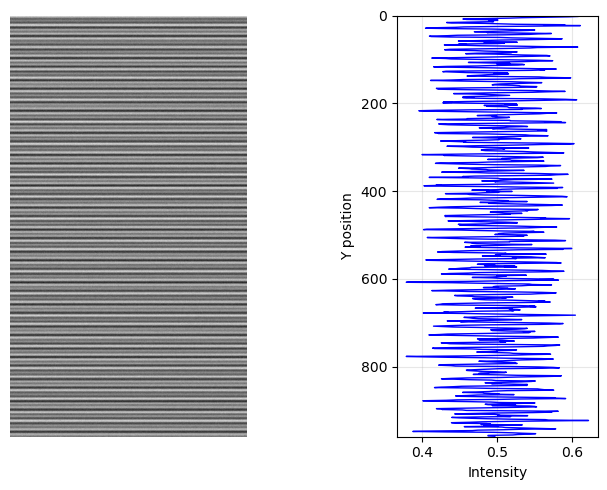

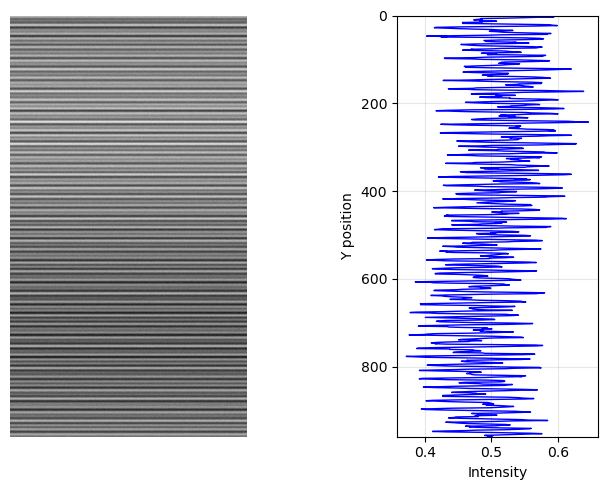

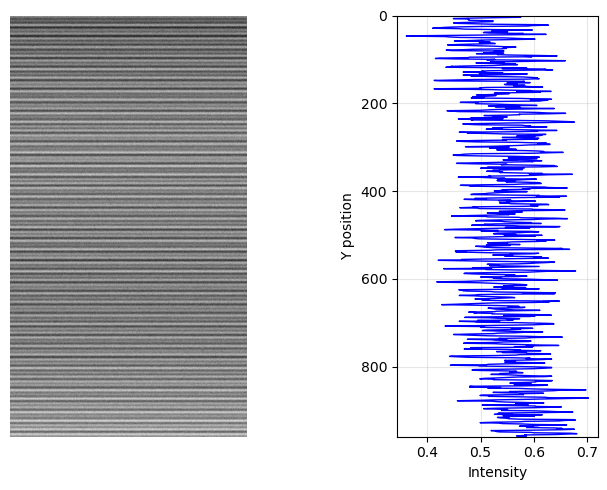

In [94]:
test_image1 = generate_test_image1()
test_image2 = generate_test_image2()
test_image3 = generate_test_image3()

def show_image_profile(image):
    fig = plt.figure(figsize=(8, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])

    ax1 = fig.add_subplot(gs[0])
    h, w = image.shape
    ax1.imshow(image, cmap='gray', aspect='equal')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[1])
    vertical_profile = image[:, w//2]
    ax2.plot(vertical_profile, np.arange(h), 'b-', linewidth=1)
    ax2.set_ylim([h, 0])
    ax2.set_xlabel('Intensity')
    ax2.set_ylabel('Y position')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
show_image_profile(test_image1)
show_image_profile(test_image2)
show_image_profile(test_image3)

In [48]:
def preprocess_luminance(image, denoise=True, normalize=True):
    img = img_as_float32(image.copy())

    # Remove outliers by clipping
    p1, p99 = np.percentile(img, [1, 99])
    img = np.clip(img, p1, p99)

    # Denoise with bilateral filter (edge-preserving)
    if denoise:
        img = restoration.denoise_bilateral(img, sigma_color=0.05, sigma_spatial=1.5, channel_axis=None)

    # Normalize to [0, 1]
    if normalize:
        img = exposure.rescale_intensity(img, out_range=(0, 1))
    return img

def compute_fft_spectrum(image):
    fft = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft)

    magnitude = np.abs(fft_shifted)
    phase = np.angle(fft_shifted)

    magnitude_log = np.log1p(magnitude)
    return magnitude_log, phase

In [49]:
def detect_periodic_lines(image, direction='vertical', freq_range=(0.05, 0.2), pixel_size_mm=0.3):
    h, w = image.shape
    
    # Compute FFT
    fft = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft)
    magnitude = np.abs(fft_shifted)
    
    # Create frequency axes
    freq_y = np.fft.fftfreq(h, d=1.0)
    freq_x = np.fft.fftfreq(w, d=1.0)
    freq_y_shifted = np.fft.fftshift(freq_y)
    freq_x_shifted = np.fft.fftshift(freq_x)
    
    # Extract 1D profile based on direction
    center_y, center_x = h // 2, w // 2
    
    if direction == 'vertical':
        # Vertical lines: use x-axis frequency
        profile = magnitude[center_y, :]
        freq_axis = np.abs(freq_x_shifted)
    else:
        # Horizontal lines: use y-axis frequency
        profile = magnitude[:, center_x]
        freq_axis = np.abs(freq_y_shifted)
    
    # Remove DC component
    dc_idx = len(profile) // 2
    profile[dc_idx] = 0
    
    # Apply frequency range mask
    freq_mask = (freq_axis >= freq_range[0]) & (freq_axis <= freq_range[1])
    
    # Detect peaks
    peaks, properties = signal.find_peaks(
        profile,
        prominence=np.max(profile) * 0.1,
        distance=5
    )
    
    # Select peaks within frequency range
    valid_peaks = peaks[freq_mask[peaks]]
    valid_freqs = freq_axis[valid_peaks]
    valid_magnitudes = profile[valid_peaks]
    
    # Sort by magnitude
    sorted_indices = np.argsort(valid_magnitudes)[::-1]
    
    # Build detected lines list
    detected_lines = []
    for idx in sorted_indices[:5]:
        freq = valid_freqs[idx]
        period_pixels = 1.0 / freq if freq > 0 else 0
        period_mm = period_pixels * pixel_size_mm
        
        detected_lines.append({
            'frequency': freq,
            'period_pixels': period_pixels,
            'period_mm': period_mm,
            'magnitude': valid_magnitudes[idx]
        })
    
    return {
        'detected_lines': detected_lines,
        'fft_magnitude': magnitude,
        'profile': profile,
        'freq_axis': freq_axis,
        'peaks': valid_peaks
    }

In [96]:
def extract_line_component(image, target_freq, direction='vertical', bandwidth=0.01):
    h, w = image.shape
    
    # Compute FFT
    fft = np.fft.fft2(image)
    fft_shifted = np.fft.fftshift(fft)
    
    # Create frequency grids
    freq_y = np.fft.fftfreq(h, d=1.0)
    freq_x = np.fft.fftfreq(w, d=1.0)
    freq_y_grid, freq_x_grid = np.meshgrid(
        np.fft.fftshift(freq_y),
        np.fft.fftshift(freq_x),
        indexing='ij'
    )
    
    # Create bandpass filter
    if direction == 'vertical':
        freq_grid = np.abs(freq_x_grid)
    else:
        freq_grid = np.abs(freq_y_grid)
    
    # Gaussian bandpass filter
    bandpass_filter = np.exp(-((freq_grid - target_freq) ** 2) / (2 * bandwidth ** 2))
    bandpass_filter += np.exp(-((freq_grid + target_freq) ** 2) / (2 * bandwidth ** 2))
    
    # Apply filter in frequency domain
    fft_filtered = fft_shifted * bandpass_filter
    
    # Inverse FFT
    fft_ifft_shifted = np.fft.ifftshift(fft_filtered)
    reconstructed = np.fft.ifft2(fft_ifft_shifted)
    line_component = np.real(reconstructed)
    
    return line_component

In [97]:
def visualize_fft(image, result, direction='vertical'):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # FFT magnitude spectrum
    magnitude_log = np.log1p(result['fft_magnitude'])
    axes[1].imshow(magnitude_log, cmap='viridis')
    axes[1].set_title('FFT Magnitude Spectrum (log scale)')
    axes[1].axis('off')

    # Frequency profile with peaks
    profile = result['profile']
    freq_axis = result['freq_axis']
    peaks = result['peaks']

    axes[2].plot(freq_axis, profile, 'b-', linewidth=1)
    axes[2].plot(freq_axis[peaks], profile[peaks], 'r*', markersize=10)
    axes[2].set_title(f'Frequency Profile ({direction})')
    axes[2].set_xlabel('Frequency')
    axes[2].set_ylabel('Magnitude')
    axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

def visualize_lines(image, result, direction='vertical'):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # Detected lines text
    detected_text = "Detected Lines:\n"
    for i, line in enumerate(result['detected_lines'][:3]):
        detected_text += f"\n{i+1}. Period: {line['period_mm']:.2f}mm "
        detected_text += f"({line['period_pixels']:.1f}px)\n"
        detected_text += f"   Freq: {line['frequency']:.4f}\n"

    axes[0].text(0.1, 0.5, detected_text,
                   fontsize=10, verticalalignment='center',
                   family='monospace')
    axes[0].axis('off')

    # Extract and display top 2 line components
    for i, (ax, line_info) in enumerate(zip(axes[1:], result['detected_lines'][1:5])):
        line_component = extract_line_component(
            image,
            line_info['frequency'],
            direction=direction
        )

        ax.imshow(line_component, cmap='seismic',
                 vmin=-np.std(line_component)*3,
                 vmax=np.std(line_component)*3)
        ax.set_title(f'Line Component {i+1}\n({line_info["period_mm"]:.2f}mm)')
        ax.axis('off')

    plt.tight_layout()
    return fig

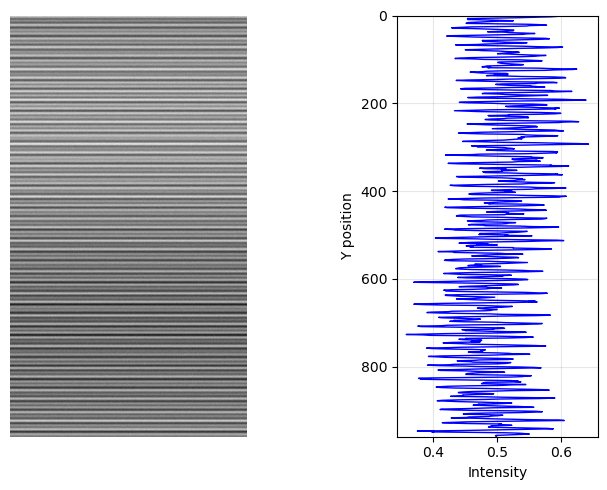

In [98]:
image = generate_test_image()
show_image_profile(image)

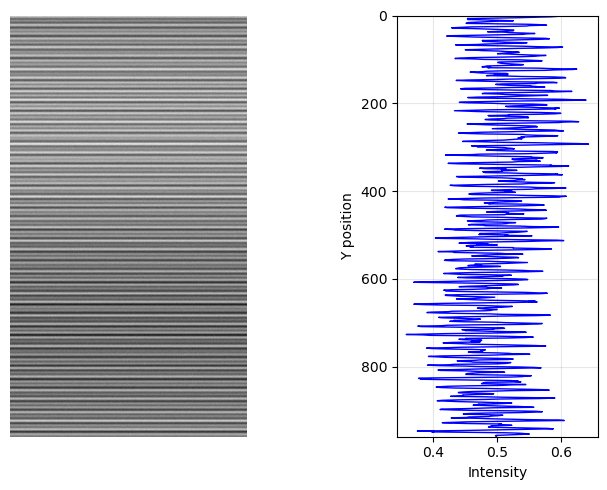

In [99]:
preprocessed = preprocess_luminance(image, denoise=True)
show_image_profile(image)

In [100]:
result = detect_periodic_lines(preprocessed, direction='vertical', freq_range=(0.05, 0.15), pixel_size_mm=0.3)
print("Detected periodic lines:")
for i, line in enumerate(result['detected_lines']):
    print(f"{i+1}. Period: {line['period_mm']:.2f}mm ({line['period_pixels']:.1f} pixels)")
    print(f"   Frequency: {line['frequency']:.4f}, Magnitude: {line['magnitude']:.1f}\n")

Detected periodic lines:
1. Period: 5.59mm (18.6 pixels)
   Frequency: 0.0537, Magnitude: 28.2

2. Period: 5.59mm (18.6 pixels)
   Frequency: 0.0537, Magnitude: 28.2

3. Period: 4.26mm (14.2 pixels)
   Frequency: 0.0704, Magnitude: 18.8

4. Period: 4.26mm (14.2 pixels)
   Frequency: 0.0704, Magnitude: 18.8

5. Period: 3.12mm (10.4 pixels)
   Frequency: 0.0963, Magnitude: 17.5



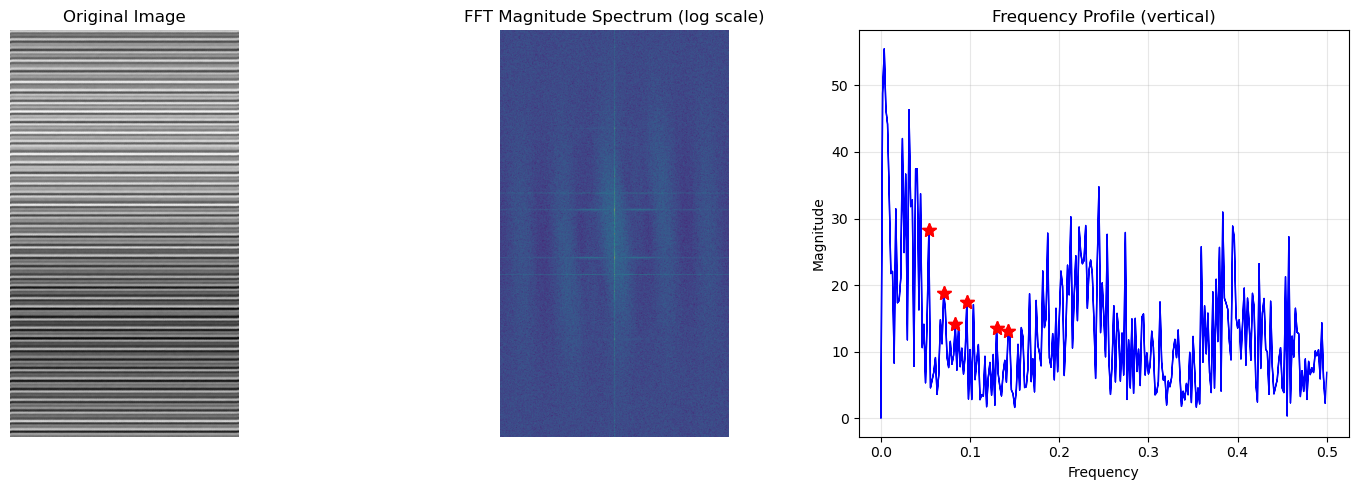

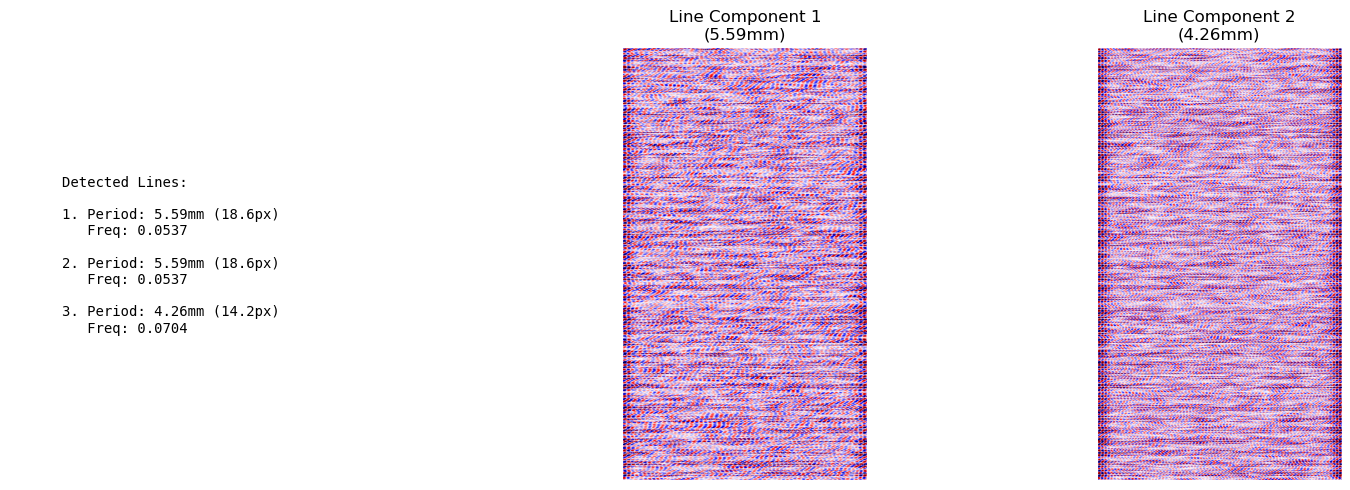

In [101]:
fig = visualize_fft(preprocessed, result, direction='vertical')
# plt.savefig('lowfreq_line_detection.png', dpi=150, bbox_inches='tight')
plt.show()

fig = visualize_lines(preprocessed, result, direction='vertical')
# plt.savefig('lowfreq_line_detection.png', dpi=150, bbox_inches='tight')
plt.show()

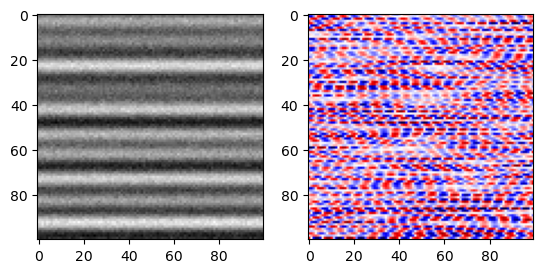

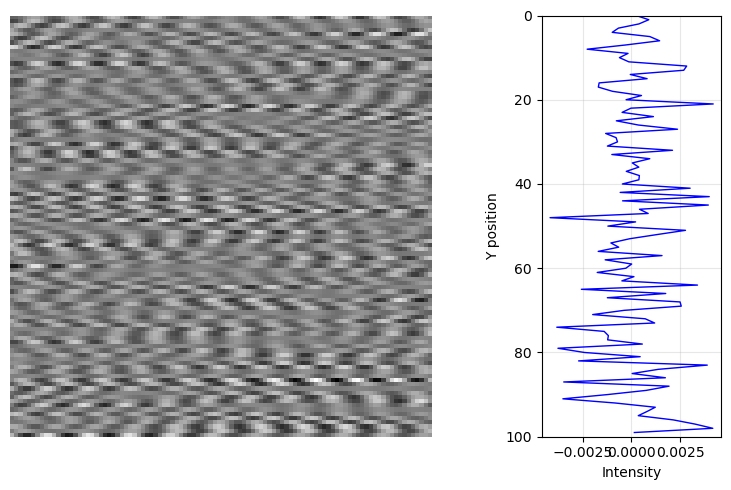

In [102]:
# 원본 이미지의 특정 영역
roi = image[100:200, 50:150]

# Line component의 동일한 영역
line_component = extract_line_component(image, 0.1019)
roi_line = line_component[100:200, 50:150]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(roi, cmap="gray")
ax2.imshow(roi_line, cmap='seismic', vmin=-np.std(line_component)*3, vmax=np.std(line_component)*3)
plt.show()

show_image_profile(roi_line)

In [103]:
## 절대값 Normalize 할 것 / 상대 값이 아닌 절대값을 사용할 것